#I. Import the libraries and files

In [ ]:
import numpy as np
import pandas as pd

#Imputing the missing values 
from sklearn.impute import SimpleImputer 

#Scaling our features
from sklearn.preprocessing import MinMaxScaler

#PCA to check the data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#Splitting the data and importing the metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score

#Models 
from lightgbm import LGBMClassifier 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
# df_train = pd.read_csv('train.csv')
# df_test = pd.read_csv('test.csv')

#II. Quick exploration of the features

In [ ]:
#Check the number of non-null lines
#Check if the data types are correct
# Check what are the numerical & categorical variables
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170000 entries, 0 to 169999
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              170000 non-null  object 
 1   Band Name                       169141 non-null  object 
 2   Band Genre                      169116 non-null  object 
 3   Band Country of Origin          169210 non-null  object 
 4   Band Debut                      169143 non-null  float64
 5   Concert ID                      169130 non-null  float64
 6   Concert Attendance              169105 non-null  float64
 7   Inside Venue                    169162 non-null  object 
 8   Rain                            169139 non-null  object 
 9   Seated                          169168 non-null  object 
 10  Personnality Trait 1            169148 non-null  float64
 11  Personnality Trait 2            169151 non-null  float64
 12  Personnality Tra

In [ ]:
#We do the same on the test set
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Id                              30000 non-null  object 
 1   Band Name                       29864 non-null  object 
 2   Band Genre                      29862 non-null  object 
 3   Band Country of Origin          29843 non-null  object 
 4   Band Debut                      29843 non-null  float64
 5   Concert ID                      29842 non-null  float64
 6   Concert Attendance              29848 non-null  float64
 7   Inside Venue                    29834 non-null  object 
 8   Rain                            29857 non-null  object 
 9   Seated                          29858 non-null  object 
 10  Personnality Trait 1            29865 non-null  float64
 11  Personnality Trait 2            29847 non-null  float64
 12  Personnality Trait 3            

In [ ]:
# Let's check now if there are some missing values
df_train.isna().sum()
# We see that there is a lot of missing values which means we have either have to replace them 
# or use a model that can handle missing values or delete the lines

Id                                  0
Band Name                         859
Band Genre                        884
Band Country of Origin            790
Band Debut                        857
Concert ID                        870
Concert Attendance                895
Inside Venue                      838
Rain                              861
Seated                            832
Personnality Trait 1              852
Personnality Trait 2              849
Personnality Trait 3              893
Personnality Trait 4              865
Concert Goer Age                  853
Concert Goer ID                   815
Height (cm)                       847
Concert Goer Country of Origin    859
Concert Enjoyment                   0
dtype: int64

#III. Cleaning the datasets


> ## 1. Looking for outliers




In [ ]:
df_train["Personnality Trait 2"].describe()

count    169151.000000
mean         -7.776188
std        3237.713866
min     -293861.500146
25%          -0.689943
50%          -0.021836
75%           0.648032
max      325834.016795
Name: Personnality Trait 2, dtype: float64

In [ ]:
df_test["Concert Attendance"].unique()

array([2.98000e+03, 8.10300e+03, 2.20260e+04, 1.09600e+03, 5.40000e+01,
       5.98740e+04, 1.48000e+02, 1.62754e+05, 4.03000e+02,         nan,
       5.98740e+08, 5.40000e+05, 2.98000e+07, 8.10300e+07, 1.62754e+09,
       2.20260e+08, 1.48000e+06, 4.03000e+06, 1.09600e+07])

In [ ]:
# Outliers are removed, I do it before replacing missing values so that the mean used to do it is not biased by extreme values.

# We do it for the test set

out_limit_H = df_train["Personnality Trait 2"].quantile(0.9995)
out_limit_L = df_train["Personnality Trait 2"].quantile(0.0006)

df_train_base = df_train[(df_train["Personnality Trait 2"] < out_limit_H) & (df_train["Personnality Trait 2"] > out_limit_L)]


mean_P2 = df_train_base["Personnality Trait 2"].mean()
df_train["Personnality Trait 2"].loc[(df_train["Personnality Trait 2"] > out_limit_H) | (df_train["Personnality Trait 2"] < out_limit_L)] = mean_P2

# Same for the attendance:
out_limit_H = 1e9

df_train_base = df_train[(df_train["Concert Attendance"] < out_limit_H)]

mean_P2 = df_train_base["Concert Attendance"].mean()
df_train["Concert Attendance"].loc[(df_train["Concert Attendance"] > out_limit_H)] = mean_P2


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# Outliers are removed, I do it before replacing missing values so that the mean used to do it is not biased by extreme values.

# We do it for the test set

out_limit_H = df_test["Personnality Trait 2"].quantile(0.9993)
out_limit_L = df_test["Personnality Trait 2"].quantile(0.0006)

df_test_base = df_test[(df_test["Personnality Trait 2"] <= out_limit_H) & (df_test["Personnality Trait 2"] >= out_limit_L)]


mean_P2 = df_test_base["Personnality Trait 2"].mean()
df_test["Personnality Trait 2"].loc[(df_test["Personnality Trait 2"] > out_limit_H) | (df_test["Personnality Trait 2"] < out_limit_L)] = mean_P2

# Same for the attendance:
out_limit_H = 1e9

df_test_base = df_test[(df_test["Concert Attendance"] < out_limit_H)]

mean_P2 = df_test_base["Concert Attendance"].mean()
df_test["Concert Attendance"].loc[(df_test["Concert Attendance"] > out_limit_H)] = mean_P2


In [ ]:
df_train["Personnality Trait 2"].describe()

count    169151.000000
mean         -0.021746
std           0.987329
min          -4.412362
25%          -0.689397
50%          -0.021970
75%           0.646901
max           3.859655
Name: Personnality Trait 2, dtype: float64

> ## 2. Replace the missing values "Insert..."




Sometimes in the dataset we have "Insert Band Genre", "Insert Band Name", "Insert Band Country of Origin" because the data where missing. So we will impute that as well by replacing them by np.nan values, so that we can generalize our main values replacing strategy, presented in the following part.

In [ ]:
broken_columns = ["Band Name","Band Genre","Band Country of Origin" ]
"Insert Band Genre" in df_train['Band Genre'].unique()

True

In [ ]:
df_train['Band Name'].where(df_train['Band Name'] != "Insert Band Name", np.nan, inplace=True)
df_train['Band Genre'].where(df_train['Band Genre'] != "Insert Band Genre", np.nan, inplace=True)
df_train['Band Country of Origin'].where(df_train['Band Country of Origin'] != "Insert Band Country of Origin", np.nan, inplace=True)

df_test['Band Name'].where(df_test['Band Name'] != "Insert Band Name", np.nan, inplace=True)
df_test['Band Genre'].where(df_test['Band Genre'] != "Insert Band Genre", np.nan, inplace=True)
df_test['Band Country of Origin'].where(df_test['Band Country of Origin'] != "Insert Band Country of Origin", np.nan, inplace=True)

In [ ]:
"Insert Band Genre" in df_test['Band Genre'].unique()

False

> ## 3. Replacing the majority of the missing values




After analyzing our dataset, we were able to retrive some of the missing values. Exemple, if the Band Debut is "1971" and we are missing the "Band Name and the "Band Genre", we know by looking at our data (most frequent category in this sub category) that is it "Joystick Army" and "Pop Music". Therefore, we were able to impute the missing values for the following features : Band Name, Band Genre, Band Country of Origin, Band Debut, Rain, Concert Attendance, Concert Goer Age, Height and all Personality Traits 1 to 4, for the training set as well as the training set.

We do this for every np.nan value, this is the reason we replaced the "Insert..." type values by np.nan in the earlier section.

In [ ]:
def find_num_value(pivot ,targ_column : str, source_column : str,df_origin):
    for value in df_origin[targ_column].loc[df_origin[source_column] == pivot]:
        if not np.isnan(value) :
            return value
    return np.nan

def find_String_value(pivot ,targ_column : str, source_column : str,df_origin):
    for value in df_origin[targ_column].loc[df_origin[source_column] == pivot]:
        if type(value)==str:
            return value
    return np.nan

def apply_num(df,df_origin, targ_column : str, source_column : str):
    df[targ_column].loc[df[targ_column].isna()] = df[source_column].loc[df[targ_column].isna()].apply(lambda x : find_num_value(pivot=x,targ_column=targ_column,source_column=source_column,df_origin=df_origin))
    return df

def apply_string(df,df_origin,targ_column : str, source_column : str):
    df[targ_column].loc[df[targ_column].isna()] = df[source_column].loc[df[targ_column].isna()].apply(lambda x : find_String_value(pivot = x,targ_column=targ_column,source_column=source_column,df_origin=df_origin))
    return df

In [ ]:
#For the training set

apply_string(df=df_train,df_origin=df_train,targ_column='Band Genre',source_column='Band Name')
apply_string(df=df_train,df_origin=df_train,targ_column='Band Country of Origin',source_column='Band Name')
apply_string(df=df_train,df_origin=df_train,targ_column='Concert Goer Country of Origin',source_column='Concert Goer ID')

apply_num(df=df_train,df_origin=df_train,targ_column='Band Debut',source_column='Band Name')
apply_num(df=df_train,df_origin=df_train,targ_column='Rain',source_column='Concert ID')
apply_num(df=df_train,df_origin=df_train,targ_column='Concert Attendance',source_column='Concert ID')
apply_num(df=df_train,df_origin=df_train,targ_column='Concert Goer Age',source_column='Concert Goer ID')
apply_num(df=df_train,df_origin=df_train,targ_column='Height (cm)',source_column='Concert Goer ID')
apply_num(df=df_train,df_origin=df_train,targ_column='Personnality Trait 1',source_column='Concert Goer ID')
apply_num(df=df_train,df_origin=df_train,targ_column='Personnality Trait 2',source_column='Concert Goer ID')
apply_num(df=df_train,df_origin=df_train,targ_column='Personnality Trait 3',source_column='Concert Goer ID')
apply_num(df=df_train,df_origin=df_train,targ_column='Personnality Trait 4',source_column='Concert Goer ID')

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
0,ConcertExperience_180106,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,concert_goer_1985,140.0,Paraguay,Did Not Enjoy
1,ConcertExperience_146268,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,concert_goer_1874,158.0,United Kingdom (UK),Enjoyed
2,ConcertExperience_128743,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,concert_goer_442,159.0,United States of America (USA),Did Not Enjoy
3,ConcertExperience_140839,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,concert_goer_1149,150.0,Canada,Worst Concert Ever
4,ConcertExperience_19149,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,concert_goer_930,166.0,United Kingdom (UK),Did Not Enjoy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,ConcertExperience_14055,Crazy Joystick Cult,RnB,Canada,1985.0,70.0,162754.0,True,False,False,-0.095021,0.175175,0.914245,0.357359,50.0,concert_goer_707,180.0,United States of America (USA),Did Not Enjoy
169996,ConcertExperience_192792,Crazy Joystick Cult,RnB,Canada,1985.0,963.0,54.0,False,False,False,-0.733719,-0.285776,-0.323312,0.641180,71.0,concert_goer_1373,143.0,Bulgaria,Worst Concert Ever
169997,ConcertExperience_152942,"Why Frogs, Why?",Heavy Metal,Canada,2005.0,764.0,54.0,False,False,False,0.744969,-0.965547,1.020598,1.027389,27.0,concert_goer_1286,176.0,Canada,Did Not Enjoy
169998,ConcertExperience_138957,Twilight of the Joystick Gods,Hip Hop/Rap,United States of America (USA),1995.0,694.0,22026.0,False,True,True,0.821976,0.351411,0.175762,1.455654,39.0,concert_goer_1845,176.0,Canada,Did Not Enjoy


In [ ]:
#we do the same for the test set

apply_string(df=df_test,df_origin=df_test,targ_column='Band Genre',source_column='Band Name')
apply_string(df=df_test,df_origin=df_test,targ_column='Band Country of Origin',source_column='Band Name')
apply_string(df=df_test,df_origin=df_test,targ_column='Concert Goer Country of Origin',source_column='Concert Goer ID')

apply_num(df=df_test,df_origin=df_test,targ_column='Band Debut',source_column='Band Name')
apply_num(df=df_test,df_origin=df_test,targ_column='Rain',source_column='Concert ID')
apply_num(df=df_test,df_origin=df_test,targ_column='Concert Attendance',source_column='Concert ID')
apply_num(df=df_test,df_origin=df_test,targ_column='Concert Goer Age',source_column='Concert Goer ID')
apply_num(df=df_test,df_origin=df_test,targ_column='Height (cm)',source_column='Concert Goer ID')
apply_num(df=df_test,df_origin=df_test,targ_column='Personnality Trait 1',source_column='Concert Goer ID')
apply_num(df=df_test,df_origin=df_test,targ_column='Personnality Trait 2',source_column='Concert Goer ID')
apply_num(df=df_test,df_origin=df_test,targ_column='Personnality Trait 3',source_column='Concert Goer ID')
apply_num(df=df_test,df_origin=df_test,targ_column='Personnality Trait 4',source_column='Concert Goer ID')

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin
0,ConcertExperience_70055,The Crazy Heroes of Devon,Rock n Roll,United States of America (USA),1980.0,350.0,2980.0,True,False,True,1.065107,0.057660,0.249639,-0.933976,74.0,concert_goer_1587,165.0,United States of America (USA)
1,ConcertExperience_34799,Joystick for the Jockies,Hip Hop/Rap,United States of America (USA),2014.0,173.0,8103.0,True,True,False,-0.886947,0.801365,0.525624,0.176655,29.0,concert_goer_293,151.0,Kenya
2,ConcertExperience_100410,Puddle of Joystick,Rock n Roll,Canada,2010.0,502.0,2980.0,True,True,False,0.744700,-0.797531,-0.034166,-0.226052,27.0,concert_goer_1068,146.0,Canada
3,ConcertExperience_106446,Flight of the Knickers,Hip Hop/Rap,Canada,2014.0,532.0,22026.0,True,False,False,-0.134180,-0.361512,0.969404,-2.341205,38.0,concert_goer_1315,183.0,United States of America (USA)
4,ConcertExperience_127249,Devon Revival,RnB,United States of America (USA),1992.0,636.0,2980.0,False,False,False,1.407366,-0.084155,-0.673233,1.733714,21.0,concert_goer_1777,177.0,Fiji
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,ConcertExperience_82288,Joystick of the Big Knickers,Hip Hop/Rap,United States of America (USA),1979.0,411.0,2980.0,True,False,False,-0.421714,-1.549670,-0.351770,0.132489,42.0,concert_goer_1710,178.0,United States of America (USA)
29996,ConcertExperience_27139,Big Division,Hip Hop/Rap,United States of America (USA),1978.0,135.0,8103.0,True,False,False,0.615087,-0.047092,0.339228,0.820159,37.0,concert_goer_1758,186.0,Canada
29997,ConcertExperience_197434,Crazyplay,Pop Music,United States of America (USA),1995.0,987.0,8103.0,False,False,True,-1.396551,-0.508627,-1.692584,1.640931,45.0,concert_goer_1481,158.0,Greece
29998,ConcertExperience_166029,Lord of the Crazy Frogs,RnB,United States of America (USA),1968.0,830.0,8103.0,False,True,False,0.168073,-0.785460,0.898273,1.608389,36.0,concert_goer_1461,170.0,United Kingdom (UK)



> ## 4. Replace the last missing values




We still have some missing values, therefore we will impute them

In [ ]:
df_test.isna().sum()

Id                                  0
Band Name                         161
Band Genre                          2
Band Country of Origin              2
Band Debut                          1
Concert ID                        158
Concert Attendance                  0
Inside Venue                      166
Rain                                0
Seated                            142
Personnality Trait 1                1
Personnality Trait 2                3
Personnality Trait 3                2
Personnality Trait 4                0
Concert Goer Age                    0
Concert Goer ID                   145
Height (cm)                         1
Concert Goer Country of Origin      1
dtype: int64

In [ ]:
# IMPUTE MISSING VALUES 

impute_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
impute_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

numeric_columns_names = ['Band Debut','Concert Attendance','Personnality Trait 3','Personnality Trait 4','Personnality Trait 1','Personnality Trait 2','Concert Goer Age', 'Height (cm)']
categorical_columns_names = ['Band Name','Concert ID', 'Band Genre', 'Band Country of Origin','Concert Goer ID','Concert Goer Country of Origin', 'Inside Venue', 'Rain', 'Seated']


#For the training set

#Impute Mean for numeric columns
impute_mean = impute_mean.fit(df_train[numeric_columns_names])
df_train[numeric_columns_names] = impute_mean.transform(df_train[numeric_columns_names])

#Impute Most Frequent for categorical columns
impute_most_frequent = impute_most_frequent.fit(df_train[categorical_columns_names])
df_train[categorical_columns_names] = impute_most_frequent.transform(df_train[categorical_columns_names])


#For the test set

#Impute Mean for numeric columns
impute_mean = impute_mean.fit(df_test[numeric_columns_names])
df_test[numeric_columns_names] = impute_mean.transform(df_test[numeric_columns_names])

#Impute Most Frequent for categorical columns
impute_most_frequent = impute_most_frequent.fit(df_test[categorical_columns_names])
df_test[categorical_columns_names] = impute_most_frequent.transform(df_test[categorical_columns_names])



df_train_imputed = df_train
df_test_imputed = df_test


In [ ]:
#Let's check now if there are some missing values
df_test_imputed.isna().sum()

Id                                0
Band Name                         0
Band Genre                        0
Band Country of Origin            0
Band Debut                        0
Concert ID                        0
Concert Attendance                0
Inside Venue                      0
Rain                              0
Seated                            0
Personnality Trait 1              0
Personnality Trait 2              0
Personnality Trait 3              0
Personnality Trait 4              0
Concert Goer Age                  0
Concert Goer ID                   0
Height (cm)                       0
Concert Goer Country of Origin    0
dtype: int64

#IV. Encoding and scaling our features



> ## 1. Encoding our categorical variables 



In [ ]:
#Encoding our Y output on the train set 
df_train_imputed['Concert Enjoyment'].replace('Worst Concert Ever', '0', inplace=True)
df_train_imputed['Concert Enjoyment'].replace('Did Not Enjoy', '1', inplace=True)
df_train_imputed['Concert Enjoyment'].replace('Enjoyed', '2', inplace=True)
df_train_imputed['Concert Enjoyment'].replace('Best Concert Ever', '3', inplace=True)

In [ ]:
# Delete unnecessary variables (we won't need the ID during the training)
df_train_imputed = df_train_imputed.drop(columns=['Id'])

In [ ]:
df_uniques_train = pd.DataFrame([[i, len(df_train_imputed[i].unique())] for i in df_train_imputed.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques_test = pd.DataFrame([[i, len(df_test_imputed[i].unique())] for i in df_test_imputed.columns], columns=['Variable', 'Unique Values']).set_index('Variable')

In [ ]:
binary_variables_train = list(df_uniques_train[df_uniques_train['Unique Values'] == 2].index)
binary_variables_test = list(df_uniques_test[df_uniques_test['Unique Values'] == 2].index)

In [ ]:
#Binarization : convert a single column of boolean values to a column of integers 1 or 0
df_train_imputed["Inside Venue"] = df_train_imputed["Inside Venue"].astype(int)
df_train_imputed["Rain"] = df_train_imputed["Rain"].astype(int)
df_train_imputed["Seated"] = df_train_imputed["Seated"].astype(int)

df_test_imputed["Inside Venue"] = df_test_imputed["Inside Venue"].astype(int)
df_test_imputed["Rain"] = df_test_imputed["Rain"].astype(int)
df_test_imputed["Seated"] = df_test_imputed["Seated"].astype(int)

In [ ]:
#One Hot Encoding for the categorial features
categorical_variables = ['Band Name', 'Concert ID', 'Band Genre', 'Band Country of Origin','Concert Goer ID','Concert Goer Country of Origin']
df_train_imputed = pd.get_dummies(df_train_imputed, columns = categorical_variables)
df_test_imputed = pd.get_dummies(df_test_imputed, columns = categorical_variables)

In [ ]:
df_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170000 entries, 0 to 169999
Columns: 3227 entries, Band Debut to Concert Goer Country of Origin_Zimbabwe
dtypes: float64(8), int64(3), object(1), uint8(3215)
memory usage: 536.8+ MB


In [ ]:
numeric_variables = ['Concert Attendance',
'Band Debut',
 'Height (cm)',
 'Personnality Trait 3',
 'Personnality Trait 4',
 'Personnality Trait 1',
 'Personnality Trait 2',
 'Concert Goer Age']


> ## 2. Scaling our features




We tried several methods for scaling our features

In [ ]:


# TECHNIQUE 1 : STANDARD SCALER
"""
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()


#Scale the ordinal and numerical variables
for column in [numeric_variables]:
    df_train_imputed[column] = Scaler.fit_transform(df_train_imputed[column])

#Scale the ordinal and numerical variables
for column in [numeric_variables]:
    df_test_imputed[column] = Scaler.fit_transform(df_test_imputed[column])"""

# TECHNIQUE 2 : MinMax Scaler 

#These feature are always postive, so we will scale them in the interval [0,1]
numeric_variables1= ['Concert Attendance',
'Band Debut',
 'Height (cm)',
 'Concert Goer Age']

#These feature can be either positive or negative, so we will scale them in the interval [-1,1]
numeric_variables2 = [ 'Personnality Trait 3',
 'Personnality Trait 4',
 'Personnality Trait 1',
 'Personnality Trait 2',]

from sklearn.preprocessing import MinMaxScaler
mmScaler1 = MinMaxScaler()

for column in [numeric_variables1]:#For the training set
    df_train_imputed[column] = mmScaler1.fit_transform(df_train_imputed[column])

for column in [numeric_variables1]:#For the test set
    df_test_imputed[column] = mmScaler1.fit_transform(df_test_imputed[column])


mmScaler2 = MinMaxScaler((-1,1))

for column in [numeric_variables2]:#For the training set
    df_train_imputed[column] = mmScaler2.fit_transform(df_train_imputed[column])

#Scale the ordinal and numerical variables
for column in [numeric_variables2]:#For the test set
    df_test_imputed[column] = mmScaler2.fit_transform(df_test_imputed[column])

In [ ]:
#Scale numerical features
#Check after the scaling 
df_train_imputed["Personnality Trait 2"].describe().T

count    170000.000000
mean          0.061596
std           0.238700
min          -1.000000
25%          -0.099865
50%           0.061505
75%           0.223224
max           1.000000
Name: Personnality Trait 2, dtype: float64

#V. Light EDA



> ## 1. Our Y output



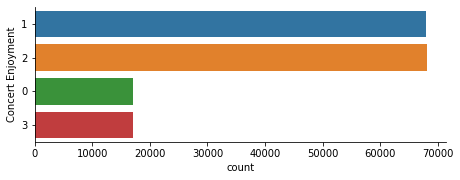

In [ ]:
# Check the distribution of our Y output
import seaborn as sns
ax = sns.catplot(y="Concert Enjoyment", kind="count", data=df_train_imputed, height=2.6, aspect=2.5, orient='h')

We can see that our classes are imbalanced. We tried different methods (Smote, oversampling, undersampling but they did not improved our model). 



> ## 2. Correlation matrix



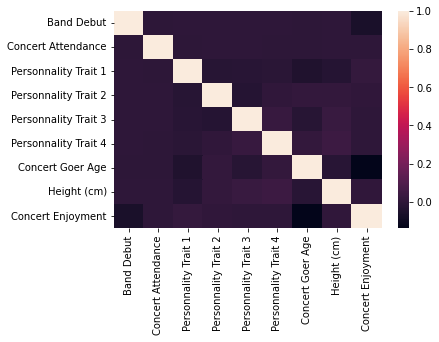

In [ ]:
# We want to see the correlation on the initial dataframe (for the numerical variables)
df_train_corr = df_train
#Encoding our Y Output
from sklearn.preprocessing import LabelEncoder
LabEnc = LabelEncoder()
df_train_corr['Concert Enjoyment'] = LabEnc.fit_transform(df_train_corr['Concert Enjoyment'])

#We don't see any strong correlation. Specially for the Concert Goer Age VS Concert Enjoyment. 
sns.heatmap(df_train_corr.corr())

#VI. Split the data

In [ ]:
#Define X and y
X = df_train_imputed.loc[ : , df_train_imputed.columns != 'Concert Enjoyment']
y = df_train_imputed['Concert Enjoyment'].astype('int')

In [ ]:
def split_data(df_train):
    X = df_train_imputed.loc[ : , df_train_imputed.columns != 'Concert Enjoyment']
    y = df_train_imputed['Concert Enjoyment'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)

# Split the data into training and test samples
X_train, X_test, y_train, y_test = split_data(df_train_imputed)

#VII. MODELS

## 1. LGBM (baseline)

In [ ]:
"""LightGBM = LGBMClassifier()
LightGBM.fit(X_train, y_train)
y_predLightGBM  = LightGBM.predict(X_test)

print(classification_report(y_test, y_predLightGBM))
print('Accuracy score: ', round(accuracy_score(y_test, y_predLightGBM), 2))"""

"LightGBM = LGBMClassifier()\nLightGBM.fit(X_train, y_train)\ny_predLightGBM  = LightGBM.predict(X_test)\n\nprint(classification_report(y_test, y_predLightGBM))\nprint('Accuracy score: ', round(accuracy_score(y_test, y_predLightGBM), 2))"

###1.1 Feature importance for our baseline model

We can see that the f1-score is low for the minirity classes. Let's try to find better hyper parameters that can improve the score.

In [ ]:
"""#FEATURE IMPORTANCE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(LightGBM.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()"""

'#FEATURE IMPORTANCE\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport warnings\nwarnings.simplefilter(action=\'ignore\', category=FutureWarning)\n\n# sorted(zip(clf.feature_importances_, X.columns), reverse=True)\nfeature_imp = pd.DataFrame(sorted(zip(LightGBM.feature_importances_,X.columns)), columns=[\'Value\',\'Feature\'])\n\nplt.figure(figsize=(20, 10))\nsns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))\nplt.title(\'LightGBM Features (avg over folds)\')\nplt.tight_layout()\nplt.show()'

In [ ]:
"""feature_imp = feature_imp.sort_values(by=['Value'], ascending=False)"""

"feature_imp = feature_imp.sort_values(by=['Value'], ascending=False)"

In [ ]:
#Top 10 most important feature
#feature_imp.head(10)

In [ ]:
#Least important feature
#feature_imp.tail(10)

##2. Parameters optimization with RandomSearchCV

In [ ]:
params = {
  'learning_rate' : [0.28],
  'max_depth' : [22],
  'min_child_weight' : [16],
  'colsample_bytree' : [0.85],
  'num_leaves': [39],
  'boosting':['dart'],
  'num_iterations' : [700],
  'objective': 'multiclass'
 }
LightGBM_RS = LGBMClassifier(learning_rate= 0.28, max_depth = 22,
min_child_weight = 16,
  colsample_bytree=  0.85,
  random_state=0,
  num_leaves= 39,
  boosting= 'dart',
  num_iterations = 700,
  objective= 'multiclass')
LightGBM_RS.fit(X_train, y_train)
y_proba  = LightGBM_RS.predict_proba(X_test)
y_pred = LightGBM_RS.predict_proba(X_test)

"""print(classification_report(y_test, y_predLightGBM_RS))
print('Accuracy score: ', round(accuracy_score(y_test, y_predLightGBM_RS), 2))"""

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


"print(classification_report(y_test, y_predLightGBM_RS))\nprint('Accuracy score: ', round(accuracy_score(y_test, y_predLightGBM_RS), 2))"

In [ ]:
y_proba  = LightGBM_RS.predict_proba(X_test)
y_pred = LightGBM_RS.predict(X_test)

In [ ]:
y_proba

array([[6.55366754e-02, 6.61008624e-01, 2.66269944e-01, 7.18475562e-03],
       [3.20075044e-01, 5.99550880e-01, 7.85936510e-02, 1.78042524e-03],
       [2.35167452e-04, 5.35500108e-03, 2.19221683e-01, 7.75188148e-01],
       ...,
       [4.57901420e-01, 5.15109423e-01, 2.65582128e-02, 4.30944071e-04],
       [2.99839986e-02, 5.63827391e-01, 4.02570354e-01, 3.61825569e-03],
       [2.16102194e-02, 4.89891704e-01, 3.72777183e-01, 1.15720894e-01]])

In [ ]:
y_pred

array([1, 1, 3, ..., 1, 1, 1])

In [ ]:
def f(row):
  i_max = np.argmax(row)
  a = row
  a = np.delete(a,i_max) 
  i_2nd = np.where(row == np.max(a))[0][0]
  if (i_max == 1) & (i_2nd == 2 ) :
    if(np.abs(row[i_2nd]-row[i_max]) < 0.01):
      return i_2nd
  if (i_max == 2) & (i_2nd == 1 ) :
    if(np.abs(row[i_2nd]-row[i_max]) < 0):
      return i_2nd
      
  return i_max

mod_pred = np.apply_along_axis(f,axis=1,arr=y_proba)


print(classification_report(y_test, mod_pred))
print('f1 score: ', f1_score(y_test, mod_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.71      0.43      0.54      3400
           1       0.68      0.74      0.71     13589
           2       0.66      0.77      0.71     13605
           3       0.68      0.32      0.43      3406

    accuracy                           0.68     34000
   macro avg       0.69      0.56      0.60     34000
weighted avg       0.68      0.68      0.67     34000

f1 score:  0.6768823529411765


In [ ]:
print(classification_report(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.71      0.43      0.54      3400
           1       0.68      0.74      0.71     13589
           2       0.67      0.76      0.71     13605
           3       0.68      0.32      0.43      3406

    accuracy                           0.68     34000
   macro avg       0.68      0.56      0.60     34000
weighted avg       0.68      0.68      0.67     34000

f1 score:  0.6765294117647059


array([1, 1, 3, ..., 1, 1, 1])

In [ ]:
f1_score(y_test, y_predLightGBM_RS,average='micro')

0.6765294117647059

#VIII. Creating the submission file

In [ ]:
#Submission
ids = df_test_imputed['Id']
ids = pd.DataFrame(ids)

lgbm_final = LGBMClassifier(learning_rate= 0.28, max_depth = 22,
min_child_weight = 16,
  colsample_bytree=  0.85,
  random_state=0,
  num_leaves= 39,
  boosting= 'dart',
  num_iterations = 700,
  objective= 'multiclass')

lgbm_final.fit(X, y)
y_predLightGBM_RS  = LightGBM_RS.predict(X_test)
predictions = LightGBM_RS.predict(df_test_imputed.drop('Id', axis=1))
Predicted = pd.DataFrame(predictions, columns=['Predicted'])


# #set the output as a dataframe and convert to csv file named submission.csv
output = pd.concat([ids, Predicted], axis=1, join='inner')
output

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


,Id,Predicted
0,ConcertExperience_70055,3
1,ConcertExperience_34799,2
2,ConcertExperience_100410,2
3,ConcertExperience_106446,2
4,ConcertExperience_127249,1
...,...,...
29995,ConcertExperience_82288,1
29996,ConcertExperience_27139,1
29997,ConcertExperience_197434,2
29998,ConcertExperience_166029,0


In [ ]:
output['Predicted'] = output['Predicted'].replace(0, "Worst Concert Ever")
output['Predicted'] = output['Predicted'].replace(1, "Did Not Enjoy")
output['Predicted'] = output['Predicted'].replace(2, "Enjoyed")
output['Predicted'] = output['Predicted'].replace(3, "Best Concert Ever")

In [ ]:
#Creation du fichier
output.to_csv('SubmissionFinal.csv', index=False)

In [ ]:
from google.colab import files
files.download("SubmissionFinal.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>